# COVID 19 classification

In [2]:
 import os
 os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
 os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate
import fastai; fastai.__version__

'1.0.60'

In [5]:
#!pip list


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [6]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## data

In [7]:
path ='/home/robert/data/covid/'; path

'/home/robert/data/covid/'

### Load Normal and pneumonia from dataset (not covids!) 

In [8]:
dfTrain = pd.read_csv(path+'train/train_split_v2_normal_pneumonia.csv', header=None)
dfTrain['valid'] = 0
dfTrain[0] = 'train/' + dfTrain[0].astype(str)
dfTrain.head()

,0,1,valid
0,train/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,normal,0
1,train/009eb222-eabc-4150-8121-d5a6d06b8ebf.png,normal,0
2,train/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.png,normal,0
3,train/017c7b5b-618e-4bc9-943c-04c6a988d992.png,normal,0
4,train/019ca122-9cdf-4704-b7a9-449c8a1c263e.png,normal,0


### Load COVID for training from covid_vicorob

In [9]:
dfTrainCovid = pd.read_csv(path+'covid_vicorob/covid_vicorob.csv', header=None)
dfTrainCovid['valid'] = 0
dfTrainCovid[0] = 'covid_vicorob/' + dfTrainCovid[0].astype(str)
dfTrainCovid.head()
print(len (dfTrainCovid))
#augment de training covid data 2^3
for i in range(3):
    dfTrainCovid = dfTrainCovid.append(dfTrainCovid)
print(len (dfTrainCovid))

dfTrain = dfTrain.append(dfTrainCovid)

122
976


### Validation data from Seram & Normals

In [10]:
dfTest = pd.read_csv(path+'test/test_split_v2_normal_pneumonia.csv',header=None)
dfTest['valid'] = 1
dfTest[0] = 'test/' + dfTest[0].astype(str)
dfTest.head()

,0,1,valid
0,test/009482dc-3db5-48d4-8580-5c89c4f01334.png,normal,1
1,test/00a85be6-6eb0-421d-8acf-ff2dc0007e8a.png,normal,1
2,test/00f87de5-5fe0-4921-93ea-914d7e683266.png,normal,1
3,test/01f11e57-5c11-4ab0-9312-d88c3826721c.png,normal,1
4,test/029216c8-ea0d-47bb-88fd-bf611cc5d1fc.png,normal,1


In [11]:
dfTestCovid = pd.read_csv(path+'seram/covid_seram.csv',header=None)
dfTestCovid['valid'] = 1
dfTestCovid[0] = 'seram/' + dfTestCovid[0].astype(str)
dfTestCovid.head()
dfTest= dfTest.append(dfTestCovid)

In [12]:
df = dfTrain.append(dfTest)
df.head()

,0,1,valid
0,train/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,normal,0
1,train/009eb222-eabc-4150-8121-d5a6d06b8ebf.png,normal,0
2,train/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.png,normal,0
3,train/017c7b5b-618e-4bc9-943c-04c6a988d992.png,normal,0
4,train/019ca122-9cdf-4704-b7a9-449c8a1c263e.png,normal,0


In [13]:
np.random.seed(42)

# src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
#        .split_by_rand_pct(0.2)
#        .label_from_df(label_delim=' '))

src = (ImageList.from_df(df=df,path=path)
    .split_from_df(col='valid')
    .label_from_df())

In [14]:
# original tfms = get_tranasforms(do_flip=False) 
# allowing horizontal flips only. 
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
#tfms = get_transforms(flip_vert=False)

In [15]:
#data = #ImageDataBunch.from_df(path=Path('data'), df=df, ds_tfms=get_transforms(), size=224, bs=32)

data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
data.batch_size=bs
# lesson 1 data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, resize_method=ResizeMethod.SQUISH)

In [16]:
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=tfms, size=224, resize_method=ResizeMethod.SQUISH)

In [17]:
doc (ImageDataBunch.from_folder)

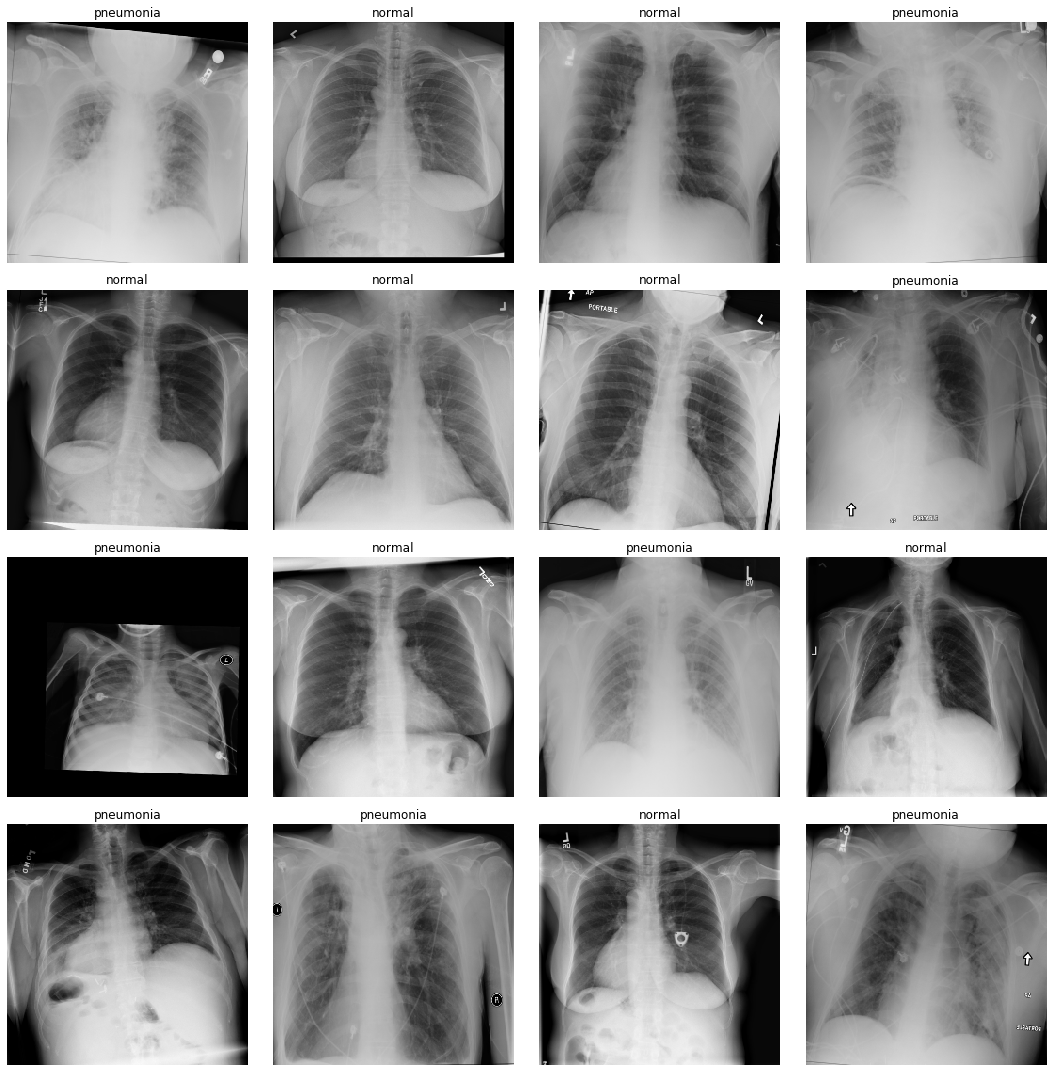

In [18]:
data.show_batch(rows=10,figsize=(15,15))

In [19]:
data.train_ds

LabelList (17492 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
normal,normal,normal,normal,normal
Path: /home/robert/data/covid

In [20]:
data.valid_ds


LabelList (1966 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
normal,normal,normal,normal,normal
Path: /home/robert/data/covid

### Convert to grayscale

In [21]:
for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
    itemList = getattr(data, itemList)
    if itemList: itemList.x.convert_mode = "L"

## learner

In [22]:
'''class fbeta_binary(Callback):
    "Computes the f_beta between preds and targets for binary text classification"

    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      
        self.beta2=beta2**2
        self.eps = eps
        self.sigmoid = sigmoid
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output
        y_pred = y_pred.softmax(dim = 1)        
        y_pred = y_pred.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==1) * (y_true==1)).float().sum()
        self.total_y_pred += (y_pred==1).float().sum()
        self.total_y_true += (y_true==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)
        res = (prec*rec)/(prec*self.beta2+rec+self.eps)*(1+self.beta2)        
        #self.metric = res.mean()
        self.metric = res     
'''

'class fbeta_binary(Callback):\n    "Computes the f_beta between preds and targets for binary text classification"\n\n    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      \n        self.beta2=beta2**2\n        self.eps = eps\n        self.sigmoid = sigmoid\n    \n    def on_epoch_begin(self, **kwargs):\n        self.TP = 0\n        self.total_y_pred = 0   \n        self.total_y_true = 0\n    \n    def on_batch_end(self, last_output, last_target, **kwargs):\n        y_pred = last_output\n        y_pred = y_pred.softmax(dim = 1)        \n        y_pred = y_pred.argmax(dim=1)\n        y_true = last_target.float()\n        \n        self.TP += ((y_pred==1) * (y_true==1)).float().sum()\n        self.total_y_pred += (y_pred==1).float().sum()\n        self.total_y_true += (y_true==1).float().sum()\n    \n    def on_epoch_end(self, **kwargs):\n        prec = self.TP/(self.total_y_pred+self.eps)\n        rec = self.TP/(self.total_y_true+self.eps)\n        res = (prec*rec)/(prec*self

In [23]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

arch = models.resnet50
#arch = models.densenet161
#learn = cnn_learner(data, arch, metrics=[accuracy, Precision(), AUROC(), error_rate])
learn = cnn_learner(data, arch, metrics=[accuracy, Precision(), error_rate])


In [120]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03
Min loss divided by 10: 7.59E-04


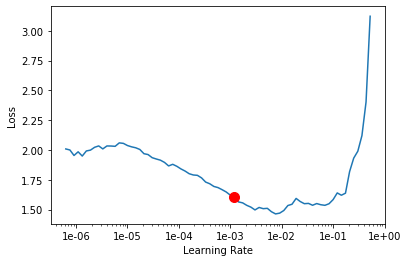

In [121]:
learn.recorder.plot(suggestion=True)

In [122]:
lr = 1e-03

In [123]:
learn.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time
0,0.621065,0.392865,0.886572,0.857899,0.113428,01:22
1,0.482642,0.304132,0.887589,0.878625,0.112411,01:23
2,0.328944,0.217689,0.919634,0.867305,0.080366,01:20
3,0.278674,0.200832,0.920651,0.949987,0.079349,01:22
4,0.254159,0.181251,0.930315,0.953792,0.069685,01:23
5,0.253403,0.179946,0.936419,0.957639,0.063581,01:21
6,0.209330,0.159436,0.942523,0.912656,0.057477,01:24
7,0.177772,0.153035,0.945066,0.949249,0.054934,01:23
8,0.198333,0.153368,0.948627,0.951102,0.051373,01:23
9,0.184333,0.141163,0.953713,0.955685,0.046287,01:21


/home/robert/miniconda2/envs/fastai-3.6/lib/python3.6/site-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [124]:
learn.save('stage-1-256-dn50')

In [125]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [126]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['COVID-19', 'normal', 'pneumonia'], 3, 17492, 1966)

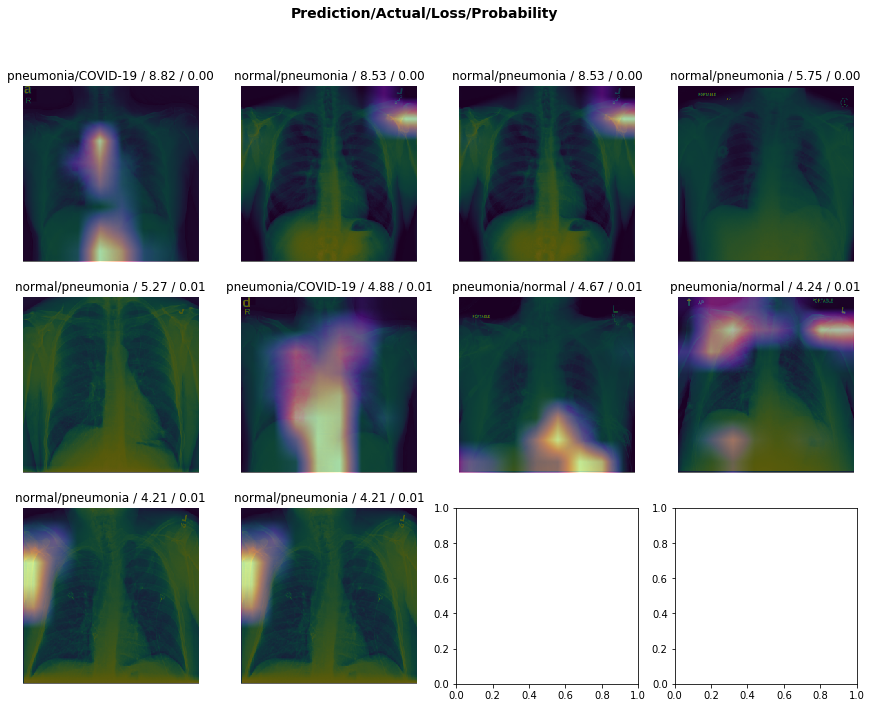

In [127]:
interp.plot_top_losses(10, figsize=(15,11), heatmap= True)

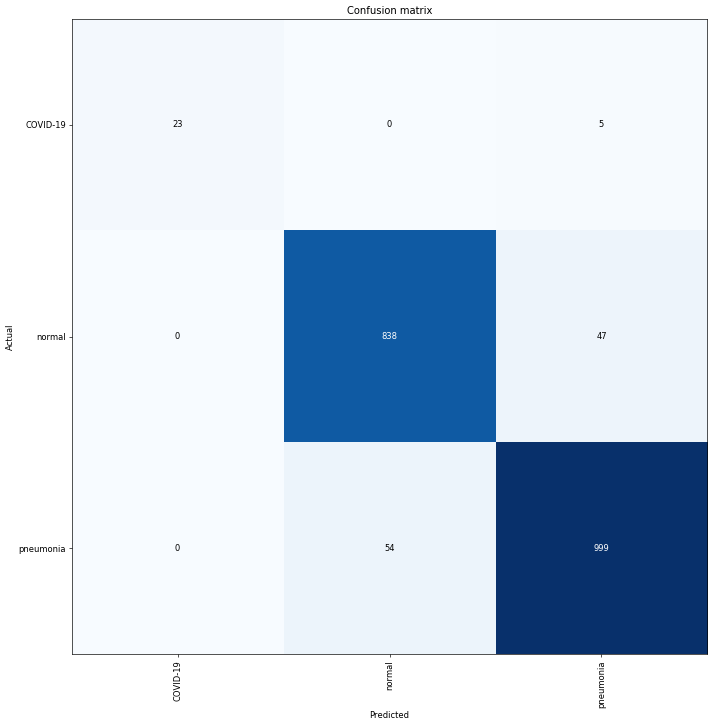

In [128]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [129]:
interp.most_confused(min_val=1)

[('pneumonia', 'normal', 54),
 ('normal', 'pneumonia', 47),
 ('COVID-19', 'pneumonia', 5)]

In [130]:
learn.unfreeze()

In [131]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 9.12E-08


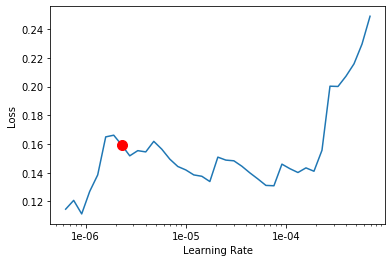

In [132]:
learn.recorder.plot(suggestion=True)

In [133]:
learn.fit_one_cycle(20,slice(1e-5, lr/2))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time
0,0.133449,0.139606,0.946592,0.963651,0.053408,01:51
1,0.169963,0.160881,0.939471,0.883019,0.060529,01:52
2,0.157377,0.145577,0.952187,0.941471,0.047813,01:52
3,0.165335,0.177507,0.938962,0.943473,0.061038,01:56
4,0.184956,0.171419,0.936928,0.845792,0.063072,01:53
5,0.177460,0.143071,0.949644,0.967131,0.050356,01:52
6,0.125296,0.122897,0.956765,0.970250,0.043235,01:52
7,0.126486,0.136184,0.955748,0.898846,0.044252,01:50
8,0.129044,0.123535,0.956765,0.938772,0.043235,01:53
9,0.099713,0.114686,0.957782,0.972007,0.042218,01:52


In [134]:
learn.save('stage-2-256-rn50')


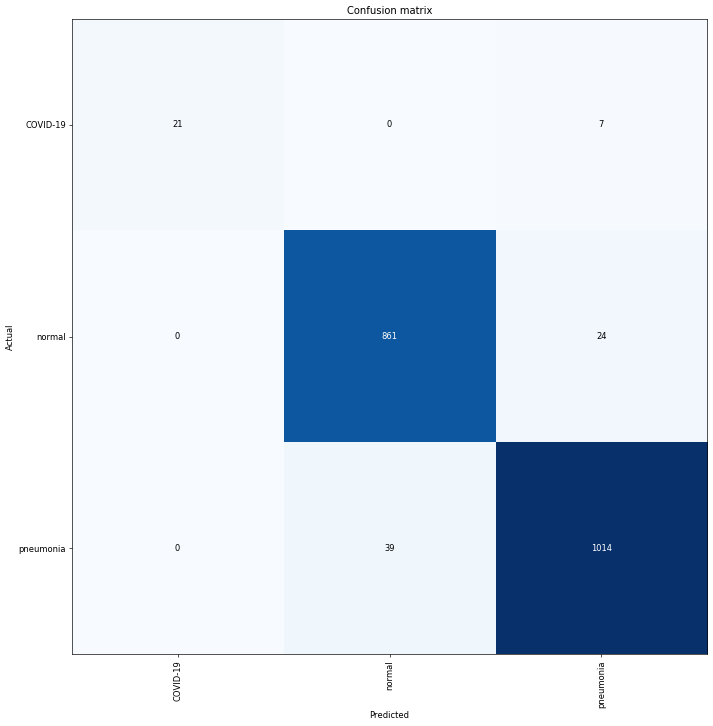

In [143]:

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### increasing image size

In [136]:
data = (src.transform(tfms, size=512)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.batch_size = bs
data.train_ds[0][0].shape

torch.Size([1, 512, 512])

In [137]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


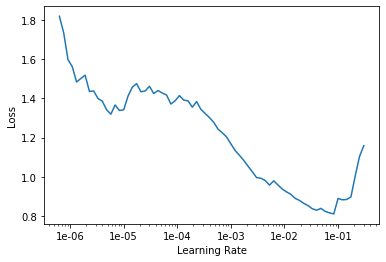

In [138]:
learn.lr_find()
learn.recorder.plot()

In [139]:
lr=1e-3/2

In [140]:
learn.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time
0,0.359492,0.260068,0.915056,0.943893,0.084944,04:09
1,0.247348,0.148992,0.949644,0.965536,0.050356,04:08
2,0.172128,0.124432,0.959308,0.972054,0.040692,04:08
3,0.132304,0.114052,0.956256,0.970983,0.043744,04:09
4,0.126850,0.109601,0.963377,0.974756,0.036623,04:08
5,0.119376,0.108129,0.963377,0.975264,0.036623,04:08
6,0.115835,0.102751,0.964903,0.975834,0.035097,04:08
7,0.097919,0.101086,0.964395,0.975571,0.035605,04:08
8,0.100326,0.108268,0.961343,0.973555,0.038657,04:10
9,0.106225,0.106097,0.964395,0.975409,0.035605,04:09


In [144]:
learn.save('stage-1-512-rn50')

In [145]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


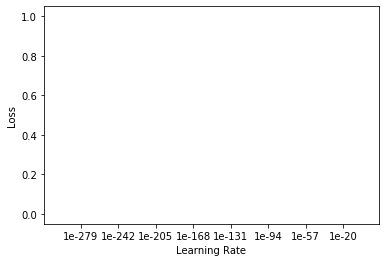

In [146]:
learn.lr_find()
learn.recorder.plot()

In [147]:
learn.fit_one_cycle(20, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time
0,0.064877,0.104048,0.962869,0.974598,0.037131,05:45
1,0.097616,0.105536,0.963377,0.974971,0.036623,05:44
2,0.087625,0.113216,0.963886,0.975055,0.036114,05:45
3,0.087658,0.099243,0.967955,0.978061,0.032045,05:47
4,0.094169,0.110457,0.962869,0.974867,0.037131,05:49
5,0.073858,0.108722,0.964395,0.975968,0.035605,05:48
6,0.086882,0.112100,0.961851,0.959842,0.038149,05:47
7,0.063949,0.123071,0.965412,0.976651,0.034588,05:45
8,0.068496,0.124617,0.954222,0.970178,0.045778,05:50
9,0.067518,0.117465,0.968464,0.978716,0.031536,05:46


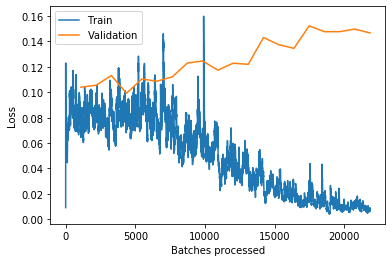

In [148]:
learn.recorder.plot_losses()

In [47]:
learn.save('stage-2-512-rn50')


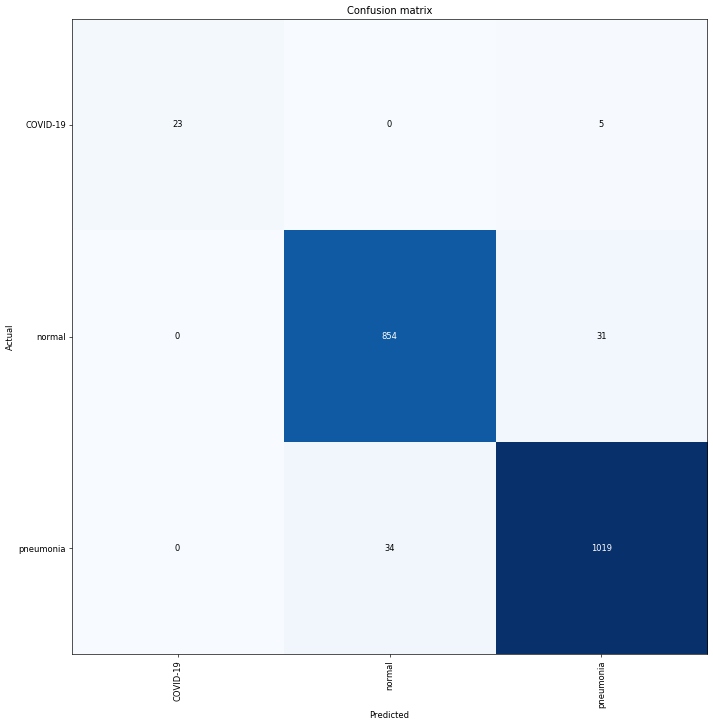

In [149]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

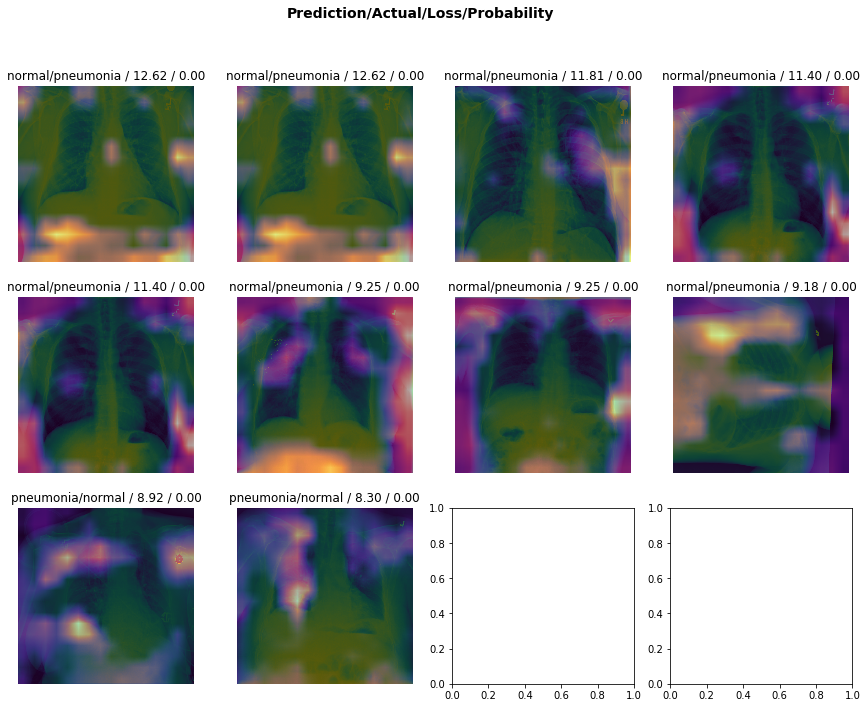

In [150]:
interp.plot_top_losses(10, figsize=(15,11), largest=True, heatmap= True)

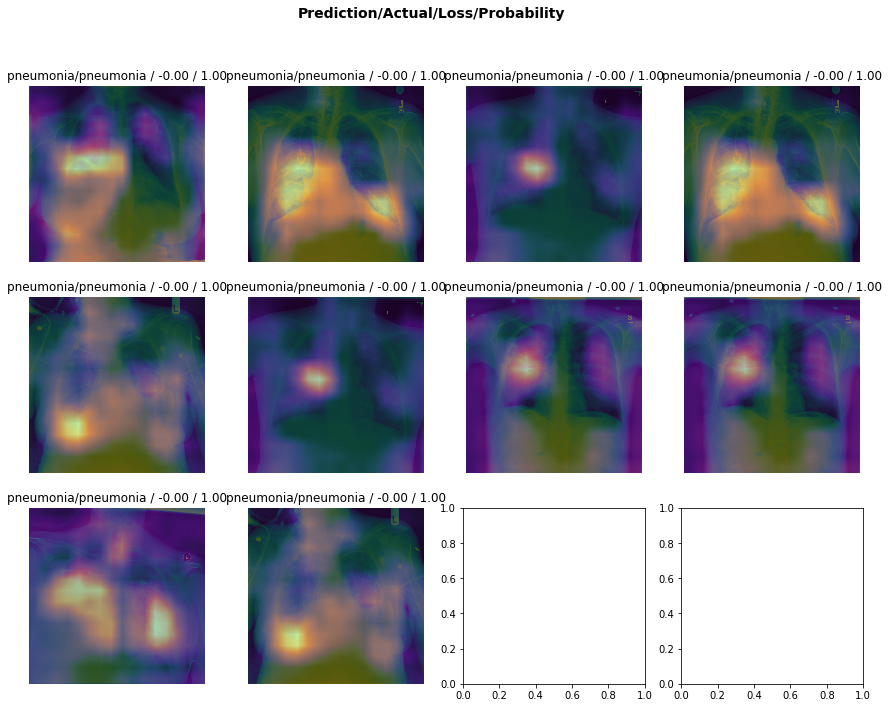

In [151]:
interp.plot_top_losses(10, figsize=(15,11), largest=False, heatmap= True)

In [152]:
learn.export('trained_resnet_512_export.pkl')

### Test on new data

In [28]:
learn = load_learner(path,'trained_resnet_512_export.pkl')

#preds,y = learn.get_preds()



In [36]:
dfTest = pd.read_csv(path+'Trueta/covid_trueta.csv',header=None)
dfTest[0] = 'Trueta/' + dfTest[0].astype(str)
dfTest.head()

#preds,y = learn.get_preds(ds_type=DatasetType.Train)

#data_test = (TabularList.from_df(test, path=nbPath, cat_names=cat_var, cont_names=cont_var,
                          # procs=procs, processor=data.processor)
#       .split_none()
#       .label_from_df(dep_var, classes=classes)
#       .databunch())
#learn.data.valid_dl = data_test.train_dl

#cls = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)

,0,1
0,Trueta/001_covid.png,COVID-19
1,Trueta/002_covid.png,COVID-19
2,Trueta/003_covid.png,COVID-19
3,Trueta/004_covid.png,COVID-19
4,Trueta/005_covid.png,COVID-19


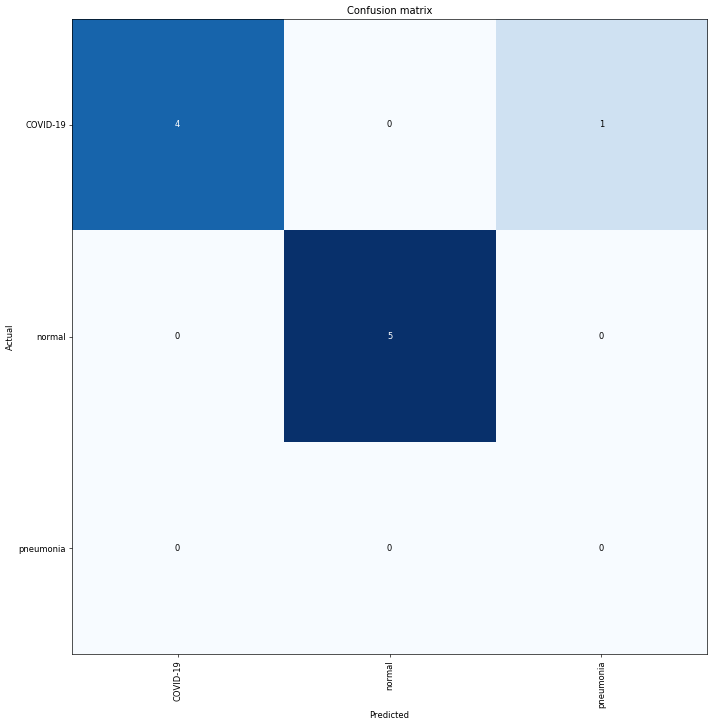

In [37]:
src = (ImageList.from_df(df=dfTest,path=path)
    .split_none()
    .label_from_df())

test = (src.transform(tfms, size=512)
        .databunch(no_check=True,bs=1).normalize(imagenet_stats))


learn.data.valid_dl = test.train_dl
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [87]:
log_preds, y = learn.TTA()
predIdxs = np.argmax(log_preds.numpy(), axis=1)


In [89]:
len(data.valid_ds)
predIdxs
log_preds
predIdxs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

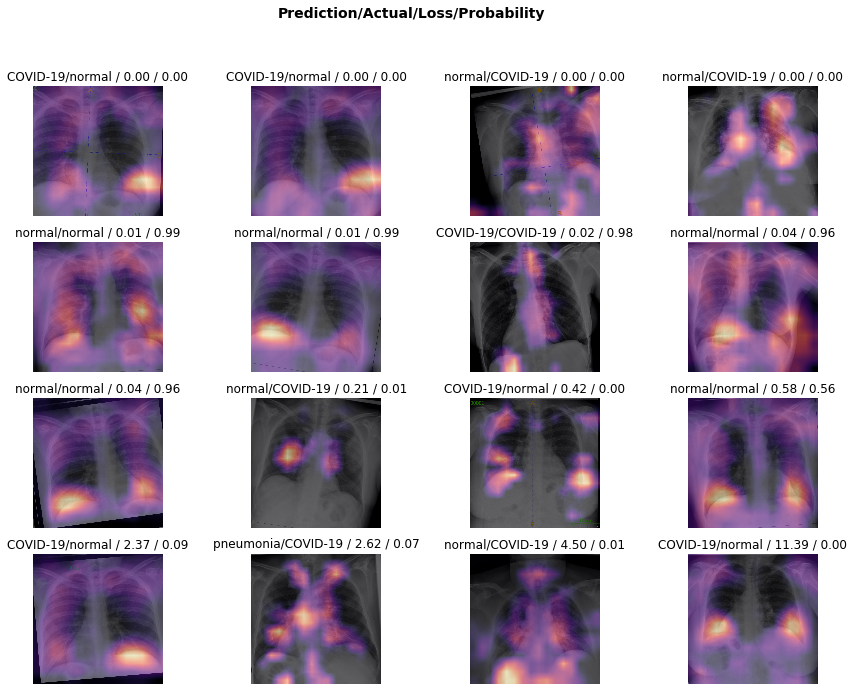

In [94]:
interp.plot_top_losses(16, figsize=(15,11), largest=False, heatmap= True)